**Тема:** Класифікація зображень. Застосування нейромереж для пошуку подібних зображень.

**Мета:** набути практичних навиків у розв’язанні задачі пошуку подібних зображень на прикладі організації CNN класифікації.

                                **Варіант 1**
**Завдання**: Побудувати CNN на основі LeNet-5 для класифікації зображень на основі датасету fashion-mnist. Зробити налаштування моделі для досягнення необхідної точності. На базі Siamese networks побудувати систему для пошуку подібних зображень в датасеті fashion-mnist. Візуалізувати отримані результати t-SNE.


In [ ]:
!pip install torchinfo --no-deps

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
from torch.utils.data import Subset, TensorDataset
import torchvision
from torchvision import transforms, datasets

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import copy
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore", category=DeprecationWarning)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
hyperparameters = {
    'batch_size': 64,
    'lr': 0.001,
    'num_epochs': 50,
    'patience': 15
}

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
])
dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

imgs = torch.stack([img for img, _ in dataset], dim=0)

mean = imgs.view(1, -1).mean(dim=1)
std = imgs.view(1, -1).std(dim=1)
print(mean, std)

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.4MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 207kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.93MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 23.6MB/s]


tensor([0.2860]) tensor([0.3530])


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

labels = dataset.targets.numpy()

train_indices, val_indices, _, _ = train_test_split(
    range(len(dataset)),
    labels,
    stratify=labels,
    test_size=0.2,
    random_state=42
)

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
print(len(train_dataset), len(val_dataset), len(test_dataset))

48000 12000 10000


In [ ]:
def label_to_category(label: int) -> str:
  return test_dataset.classes[label]

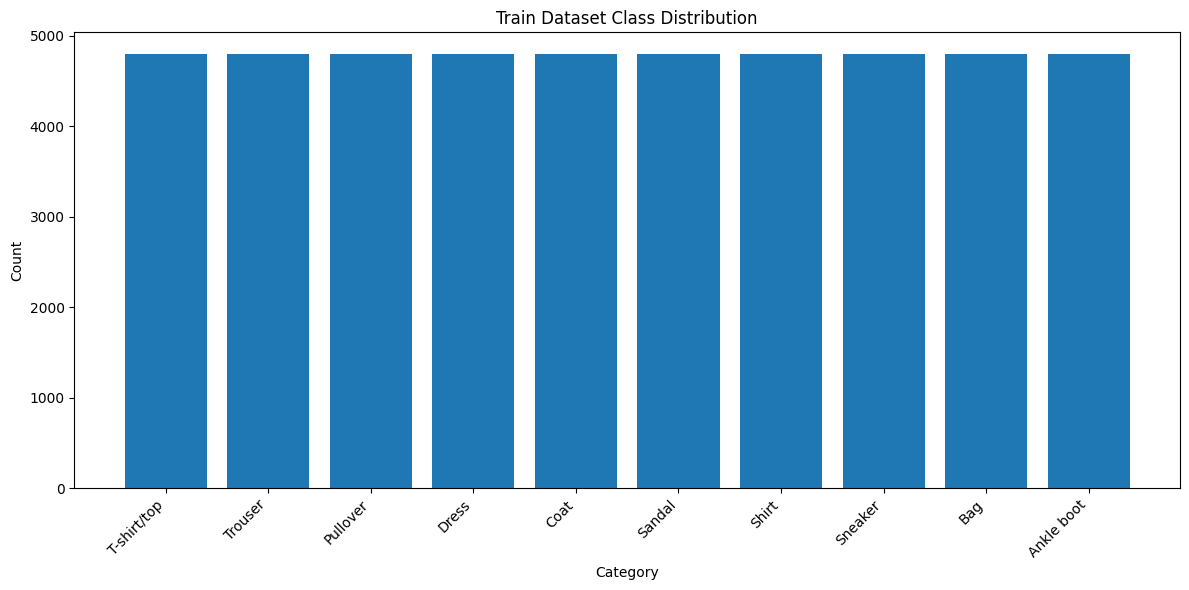

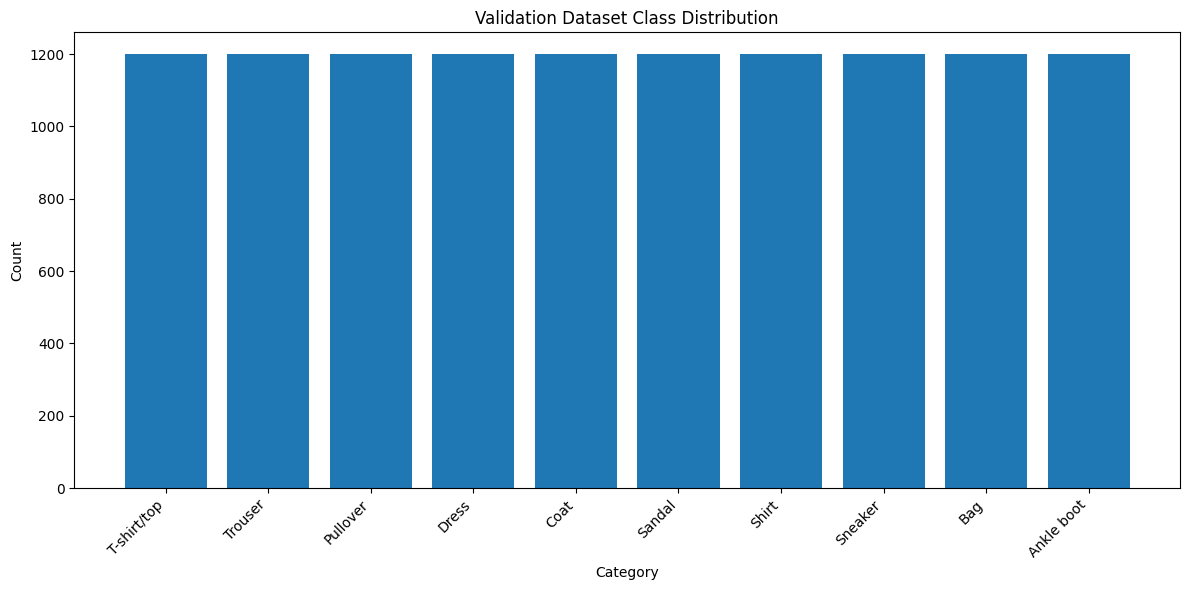

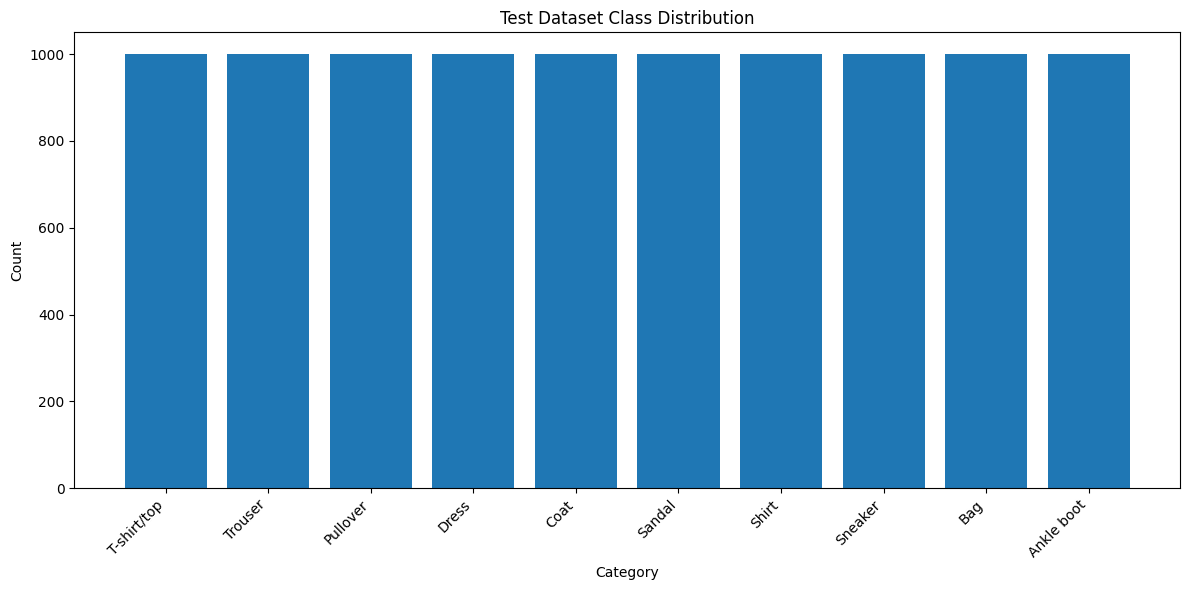

48000 12000 10000


In [ ]:
def get_class_distribution(dataset):
    labels = []
    for _, label in dataset:
        labels.append(label)
    return torch.tensor(labels)


def plot_class_distribution(labels, title):
    class_counts = torch.bincount(labels)
    classes = np.arange(len(class_counts))
    category_names = [label_to_category(c) for c in classes]

    plt.figure(figsize=(12, 6))
    plt.bar(category_names, class_counts)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.title(title)
    plt.tight_layout()
    plt.show()


train_labels = get_class_distribution(train_dataset)
val_labels = get_class_distribution(val_dataset)
test_labels = test_dataset.targets

plot_class_distribution(train_labels, 'Train Dataset Class Distribution')
plot_class_distribution(val_labels, 'Validation Dataset Class Distribution')
plot_class_distribution(test_labels, 'Test Dataset Class Distribution')

print(len(train_dataset), len(val_dataset), len(test_dataset))

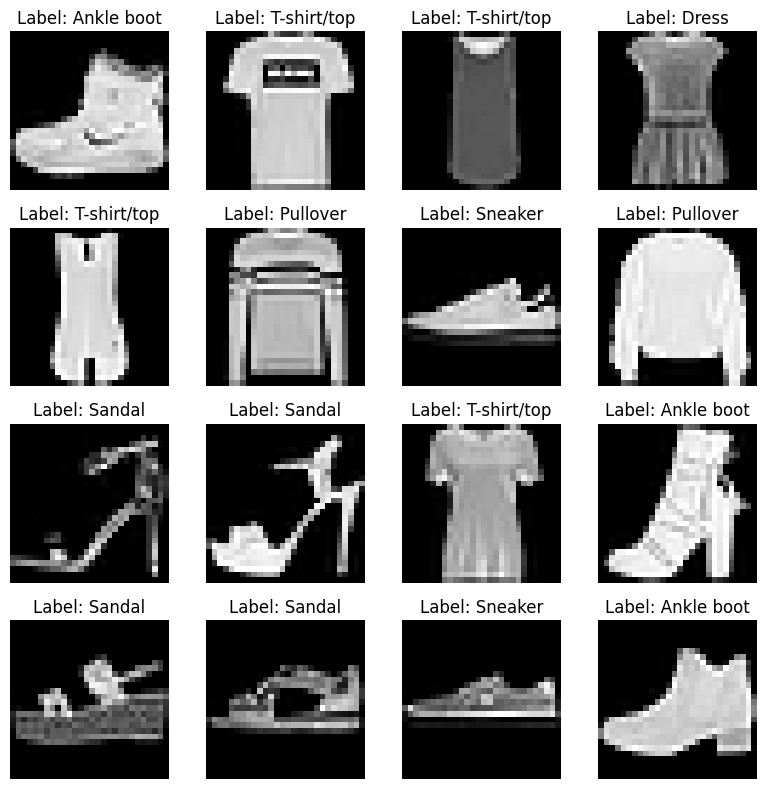

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(8, 8))

for i in range(4):
    for j in range(4):
        image, label = dataset[i * 4 + j]
        image_numpy = image.numpy().squeeze()
        axs[i, j].imshow(image_numpy, cmap='gray')
        axs[i, j].axis('off')
        axs[i, j].set_title(f"Label: {label_to_category(label)}")

plt.tight_layout()
plt.show()

In [ ]:
def img_pixel_superimpose(img, ax):
    w, h = img.shape
    color_map = plt.cm.get_cmap('gray_r')
    ax.imshow(img, cmap='gray')
    for x in range(w):
        for y in range(h):
            color = color_map(img[x][y])
            ax.annotate(str(img[x][y]), xy=(y,x), horizontalalignment='center', verticalalignment='center',
                        color=color)
            plt.axis(False)

Sneaker


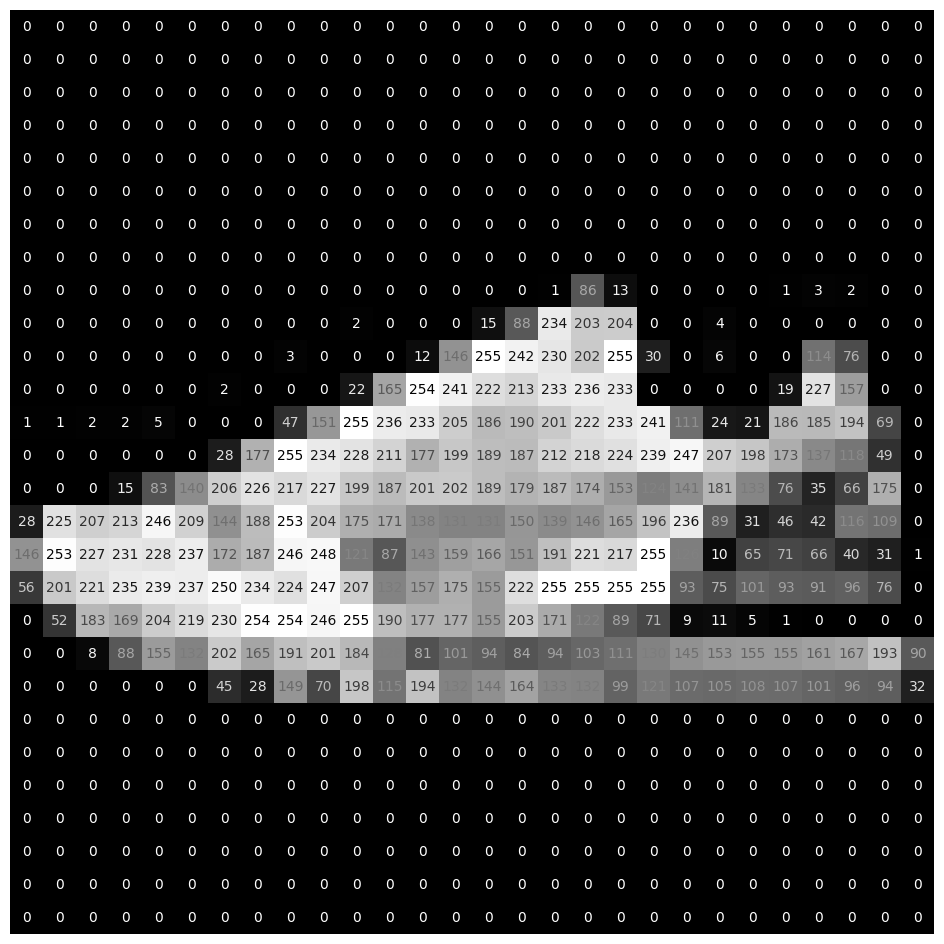

In [ ]:
fig = plt.figure(figsize = (12,12))
ax0 = fig.add_subplot(1, 1, 1)

rand_ind = torch.randint(0, len(test_dataset), size=[1]).item()

img0 = test_dataset.data[rand_ind]
print(label_to_category(test_dataset[rand_ind][1]))
img0 = img0.numpy()
img_pixel_superimpose(img0, ax0)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=hyperparameters.get('batch_size', 64), shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=hyperparameters.get('batch_size', 64), shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=hyperparameters.get('batch_size', 64), shuffle=False)

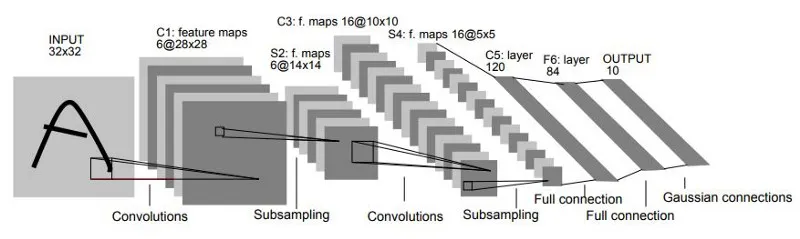

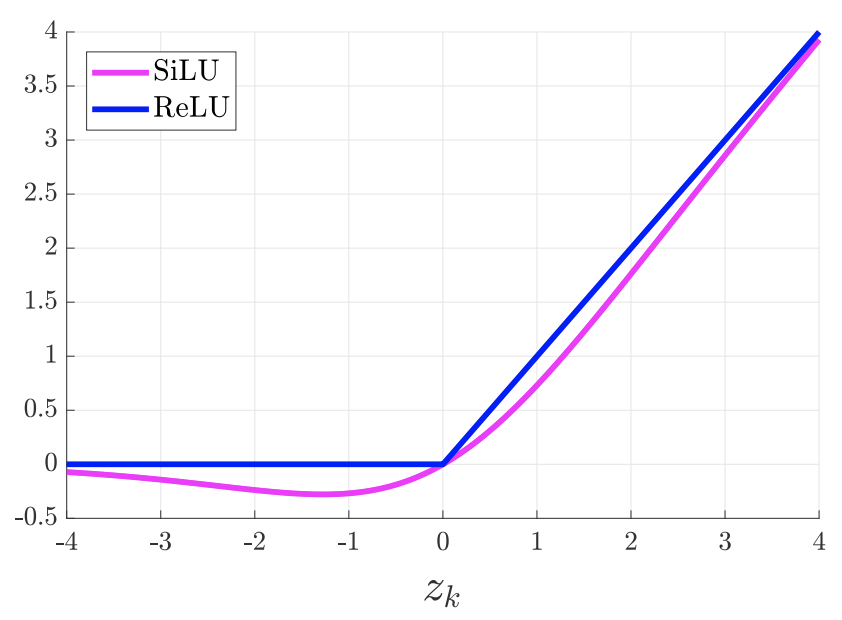

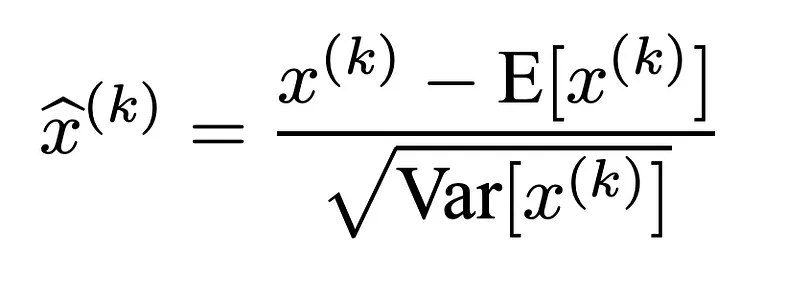

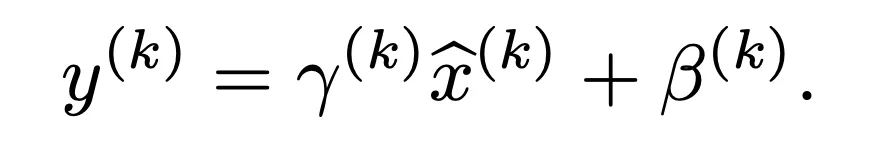

In [ ]:
class LeNet5(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet5, self).__init__()
        # Перший блок: conv -> batch norm -> relu -> max pool
        # Використовуємо padding=2 для збереження просторової розмірності
        self.convblock1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2, bias=False),
            nn.BatchNorm2d(6),
            nn.SiLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # зменшення розмірності: 28x28 -> 14x14
        )

        # Другий блок: conv -> batch norm -> relu -> max pool
        # Без додаткового padding, тому: 14x14 -> (14-5+1)=10x10, pool -> 5x5
        self.convblock2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, bias=False),
            nn.BatchNorm2d(16),
            nn.SiLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 5*5
            # Вхід: 16 каналів * 5 * 5 = 400
            nn.Flatten(),
        )

        self.classifier = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),
            nn.SiLU(),
            nn.Dropout(p=0.5),
            nn.Linear(120, 84),
            nn.SiLU(),
            nn.Dropout(p=0.4),
            nn.Linear(84, num_classes),
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x, extract_features=False):
        x = self.convblock1(x)
        x = self.convblock2(x)

        if extract_features:
            return x  #[batch_size, 400]
        else:
            x = self.classifier(x)
            return x

        return x

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        if self.best_loss is None or val_loss < self.best_loss:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
            self.counter = 0
            if self.verbose:
                print("Validation loss decreased, saving model ...")
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

In [ ]:
def calculate_accuracy(outputs, targets):
    _, preds = torch.max(outputs, 1)
    correct = (preds == targets).sum().item()
    return correct


def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience):
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_train = 0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            running_loss += loss.item() * data.size(0)
            running_corrects += calculate_accuracy(outputs, target)
            total_train += data.size(0)
            loss.backward()
            optimizer.step()

        epoch_loss = running_loss / total_train
        epoch_acc = running_corrects / total_train

        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0
        total_val = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                outputs = model(data)
                loss = criterion(outputs, target)
                val_running_loss += loss.item() * data.size(0)
                val_running_corrects += calculate_accuracy(outputs, target)
                total_val += data.size(0)
        val_loss = val_running_loss / total_val
        val_acc = val_running_corrects / total_val

        train_losses.append(epoch_loss)
        val_losses.append(val_loss)
        train_accuracies.append(epoch_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.4f} - Train Acc: {epoch_acc:.4f} - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f}")

        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early_stopping")
            break

    model.load_state_dict(early_stopping.best_model)

    history = {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_acc': train_accuracies,
        'val_acc': val_accuracies
    }
    return model, history

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import seaborn as sns


def calculate_accuracy(outputs, targets):
    _, preds = torch.max(outputs, 1)
    correct = (preds == targets).sum().item()
    return correct


def print_classification_report(model, val_loader):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    print("Classification Report:")
    print(classification_report(all_targets, all_preds))


def print_confusion_matrix(model, val_loader, class_names=test_dataset.classes):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    cm = confusion_matrix(all_targets, all_preds)

    plt.figure(figsize=(10, 8))
    if class_names is not None:
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
    else:
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")

    plt.title("Confusion Matrix")
    plt.show()


def plot_roc_curve(model, val_loader, num_classes):
    model.eval()
    all_targets = []
    all_probs = []
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            all_probs.extend(probs)
            all_targets.extend(target.cpu().numpy())
    all_targets = np.array(all_targets)
    all_probs = np.array(all_probs)

    plt.figure()
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(all_targets == i, all_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {label_to_category(i)} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()


def plot_auc_prc(model, val_loader, num_classes):
    model.eval()
    all_targets = []
    all_probs = []
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            all_probs.extend(probs)
            all_targets.extend(target.cpu().numpy())
    all_targets = np.array(all_targets)
    all_probs = np.array(all_probs)

    plt.figure()
    for i in range(num_classes):
        precision, recall, _ = precision_recall_curve(all_targets == i, all_probs[:, i])
        auc_prc = auc(recall, precision)
        plt.plot(recall, precision, label=f'Class {label_to_category(i)} (AUC-PRC = {auc_prc:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()


def calculate_top1_error(model, val_loader):
    model.eval()
    total_val = 0
    val_running_corrects = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            val_running_corrects += calculate_accuracy(outputs, target)
            total_val += data.size(0)
    val_acc = val_running_corrects / total_val
    top1_error = (1 - val_acc) * 100
    print(f"Top-1 Error Rate: {top1_error:.2f}%")


def plot_curves(history: dict):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Крива втрат')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Крива точності')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience, num_classes):
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_train = 0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            running_loss += loss.item() * data.size(0)
            running_corrects += calculate_accuracy(outputs, target)
            total_train += data.size(0)
            loss.backward()
            optimizer.step()

        epoch_loss = running_loss / total_train
        epoch_acc = running_corrects / total_train

        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0
        total_val = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                outputs = model(data)
                loss = criterion(outputs, target)
                val_running_loss += loss.item() * data.size(0)
                val_running_corrects += calculate_accuracy(outputs, target)
                total_val += data.size(0)
        val_loss = val_running_loss / total_val
        val_acc = val_running_corrects / total_val

        train_losses.append(epoch_loss)
        val_losses.append(val_loss)
        train_accuracies.append(epoch_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.4f} - Train Acc: {epoch_acc:.4f} - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f}")

        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early_stopping")
            break

    model.load_state_dict(early_stopping.best_model)

    history = {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_acc': train_accuracies,
        'val_acc': val_accuracies
    }
    return model, history

In [ ]:
from torchinfo import summary


model_lenet = LeNet5().to(device)
summary(model=model_lenet, input_size=(1, 1, 28, 28), col_width=20,
                  col_names=['input_size', 'output_size', 'num_params', 'trainable'], row_settings=['var_names'], verbose=0)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
LeNet5 (LeNet5)                          [1, 1, 28, 28]       [1, 10]              --                   True
├─Sequential (convblock1)                [1, 1, 28, 28]       [1, 6, 14, 14]       --                   True
│    └─Conv2d (0)                        [1, 1, 28, 28]       [1, 6, 28, 28]       150                  True
│    └─BatchNorm2d (1)                   [1, 6, 28, 28]       [1, 6, 28, 28]       12                   True
│    └─SiLU (2)                          [1, 6, 28, 28]       [1, 6, 28, 28]       --                   --
│    └─MaxPool2d (3)                     [1, 6, 28, 28]       [1, 6, 14, 14]       --                   --
├─Sequential (convblock2)                [1, 6, 14, 14]       [1, 400]             --                   True
│    └─Conv2d (0)                        [1, 6, 14, 14]       [1, 16, 10, 10]      2,400                True
│    └─BatchNorm2d

Epoch 1/50 - Train Loss: 1.1924 - Train Acc: 0.6513 - Val Loss: 0.4911 - Val Acc: 0.8211
Validation loss decreased, saving model ...
Epoch 2/50 - Train Loss: 0.6229 - Train Acc: 0.7799 - Val Loss: 0.4140 - Val Acc: 0.8542
Validation loss decreased, saving model ...
Epoch 3/50 - Train Loss: 0.5144 - Train Acc: 0.8181 - Val Loss: 0.3725 - Val Acc: 0.8660
Validation loss decreased, saving model ...
Epoch 4/50 - Train Loss: 0.4553 - Train Acc: 0.8380 - Val Loss: 0.3498 - Val Acc: 0.8728
Validation loss decreased, saving model ...
Epoch 5/50 - Train Loss: 0.4129 - Train Acc: 0.8541 - Val Loss: 0.3194 - Val Acc: 0.8814
Validation loss decreased, saving model ...
Epoch 6/50 - Train Loss: 0.3884 - Train Acc: 0.8625 - Val Loss: 0.3085 - Val Acc: 0.8906
Validation loss decreased, saving model ...
Epoch 7/50 - Train Loss: 0.3654 - Train Acc: 0.8701 - Val Loss: 0.2943 - Val Acc: 0.8927
Validation loss decreased, saving model ...
Epoch 8/50 - Train Loss: 0.3479 - Train Acc: 0.8770 - Val Loss: 0.285

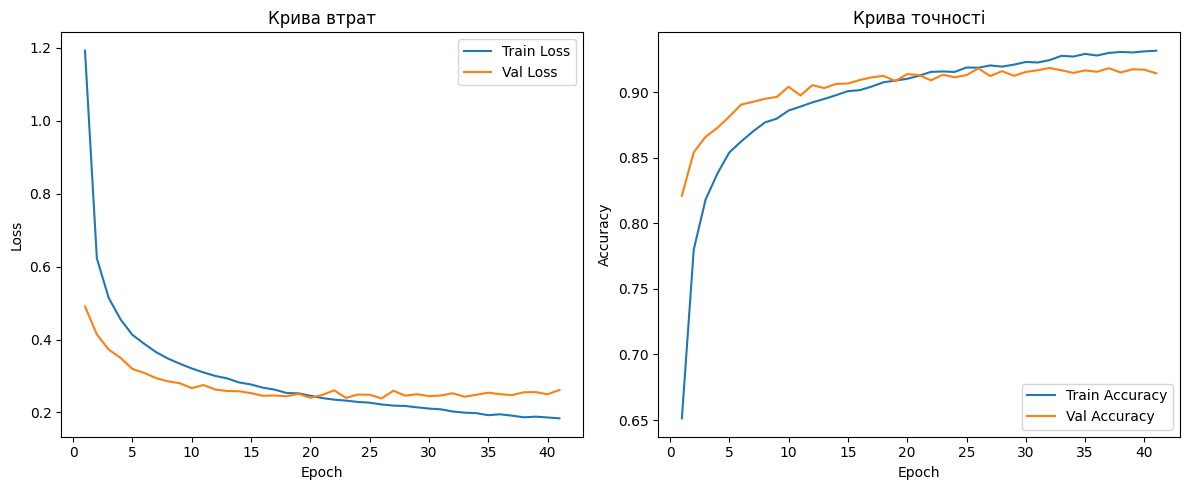

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      1200
           1       0.99      0.98      0.99      1200
           2       0.89      0.86      0.87      1200
           3       0.90      0.93      0.92      1200
           4       0.85      0.87      0.86      1200
           5       0.97      0.98      0.97      1200
           6       0.79      0.76      0.77      1200
           7       0.96      0.97      0.96      1200
           8       0.99      0.98      0.98      1200
           9       0.98      0.97      0.97      1200

    accuracy                           0.92     12000
   macro avg       0.92      0.92      0.92     12000
weighted avg       0.92      0.92      0.92     12000



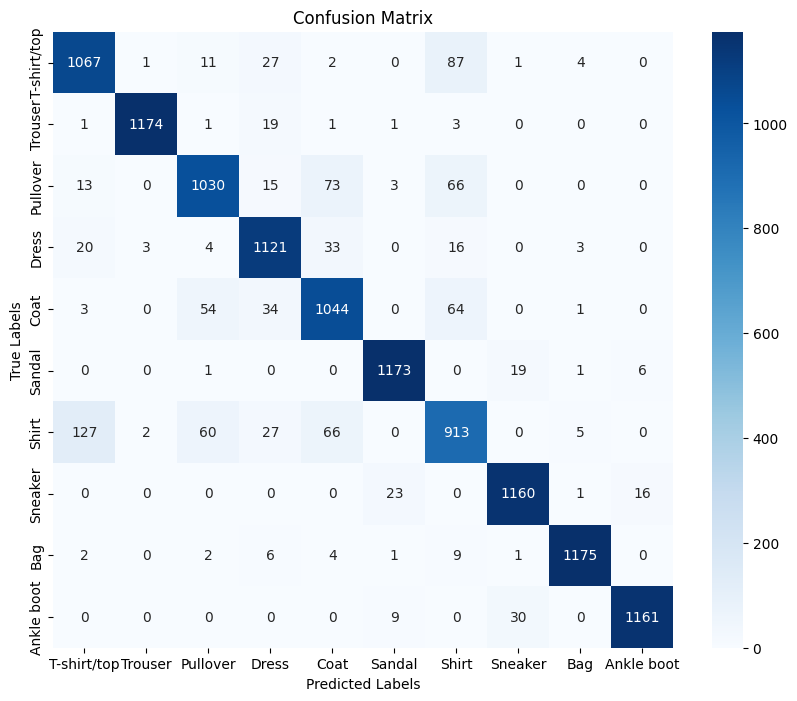

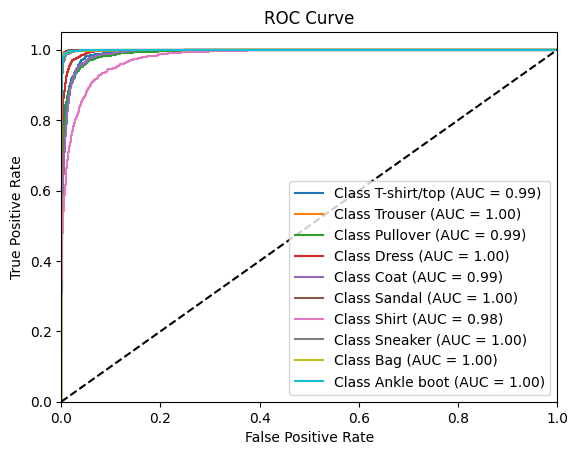

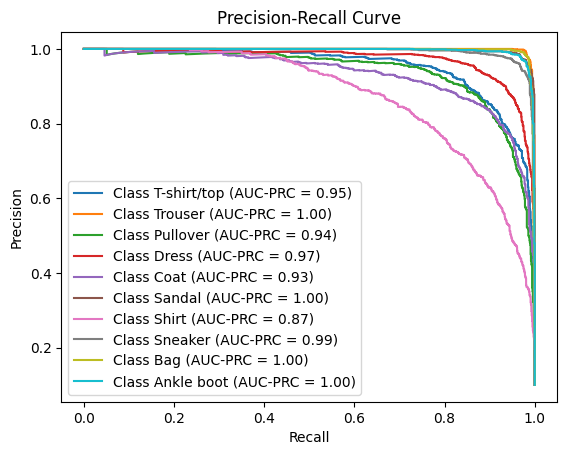

Top-1 Error Rate: 8.18%


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_lenet.parameters(), lr=hyperparameters.get('lr'))

model_lenet, history = train_model(model_lenet, train_loader, val_loader, criterion, optimizer, hyperparameters.get('num_epochs'), hyperparameters.get('patience'), 10)

plot_curves(history)
print_classification_report(model_lenet, val_loader)
print_confusion_matrix(model_lenet, val_loader)
plot_roc_curve(model_lenet, val_loader, 10)
plot_auc_prc(model_lenet, val_loader, 10)
calculate_top1_error(model_lenet, val_loader)

Точність на тестових даних: 90.71%, Loss: 0.2611
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      1000
           1       0.99      0.98      0.99      1000
           2       0.87      0.84      0.86      1000
           3       0.89      0.93      0.91      1000
           4       0.85      0.86      0.85      1000
           5       0.97      0.98      0.97      1000
           6       0.75      0.70      0.72      1000
           7       0.94      0.97      0.96      1000
           8       0.98      0.98      0.98      1000
           9       0.98      0.96      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



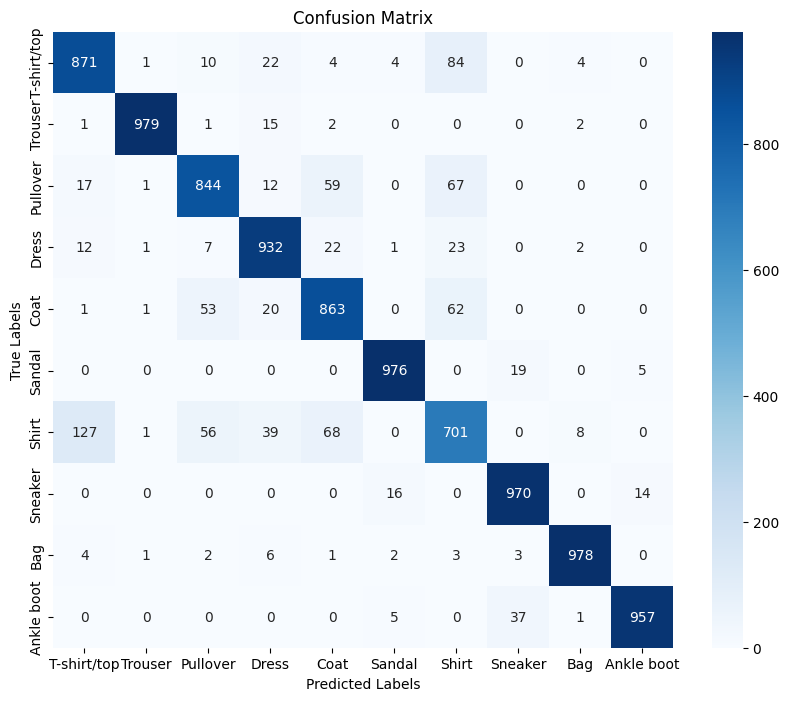

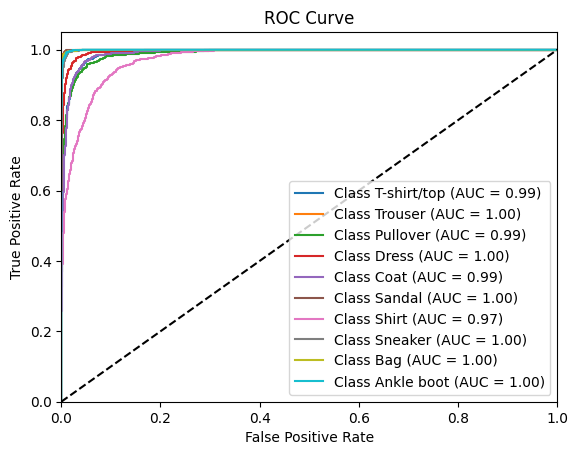

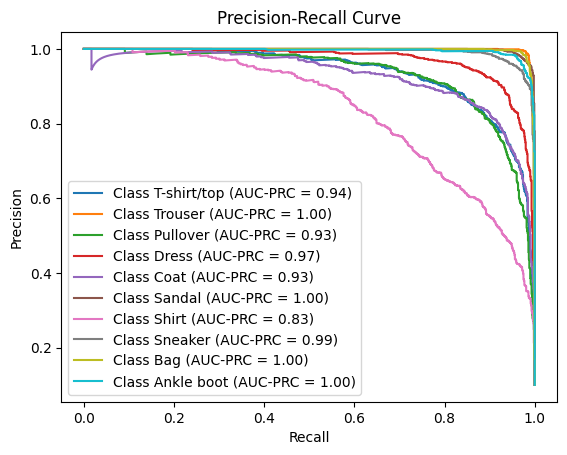

Top-1 Error Rate: 9.29%


In [ ]:
def evaluate(model, test_loader):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    correct = 0
    total = 0
    val_running_loss = 0.0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_running_loss += loss.item() * data.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return 100 * correct / total, val_running_loss / total


test_accuracy, loss = evaluate(model_lenet, test_loader)
print(f"Точність на тестових даних: {test_accuracy:.2f}%, Loss: {loss:.4f}")
print_classification_report(model_lenet, test_loader)
print_confusion_matrix(model_lenet, test_loader)
plot_roc_curve(model_lenet, test_loader, 10)
plot_auc_prc(model_lenet, test_loader, 10)
calculate_top1_error(model_lenet, test_loader)

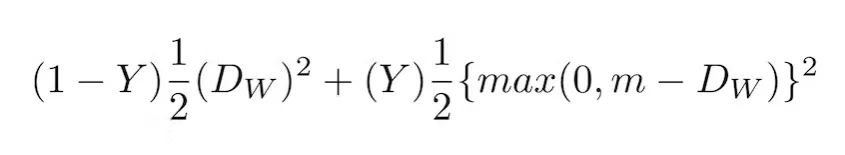, де Dw визначається як евклідова відстань між виходами

Y дорівнює 1 або 0. Якщо перше та друге зображення належать до одного класу, значення Y дорівнює 0, інакше Y дорівнює 1

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self, embedding_net):
        super(SiameseNetwork, self).__init__()
        self.embedding_net = embedding_net

    def forward_once(self, x):
        output = self.embedding_net(x, extract_features=True)
        return output

    def forward(self, x1, x2):
        output1 = self.forward_once(x1)
        output2 = self.forward_once(x2)
        return output1, output2


class ContrastiveLoss(nn.Module):

    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        #margin визначає мінімальну відстань між негативними парами, після якої штраф зникає.
        #якщо відстань між негативними зразками менша за margin, модель штрафується.

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        pos = (1-label) * torch.pow(euclidean_distance, 2)
        neg = (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        loss_contrastive = torch.mean( pos + neg )
        return loss_contrastive

In [ ]:
import random
random.seed(42)


class SiameseFashionMNIST(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.transform = transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])

    def __getitem__(self, idx):
        x1, t1 = self.dataset[idx]
        is_diff = random.randint(0, 1)
        while True:
            idx2 = random.randint(0, len(self)-1)
            x2, t2 = self.dataset[idx2]
            if is_diff == 1 and int(t1) != int(t2):
                break
            if is_diff == 0 and int(t1) == int(t2):
                break

        x1, x2 = x1[0].numpy(), x2[0].numpy()
        if self.transform is not None:
            x1, x2 = self.transform(x1), self.transform(x2)
        return x1, x2, int(is_diff)

    def __len__(self):
        return len(self.dataset)

In [ ]:
el = next(iter(SiameseFashionMNIST(val_dataset)))
el[0].shape, el[1].shape, el[2]

(torch.Size([1, 28, 28]), torch.Size([1, 28, 28]), 0)

In [ ]:
def validate_siamese(model, val_loader, criterion):
    model.eval()
    total = 0
    correct = 0
    val_loss = 0.0
    with torch.no_grad():
        for batch_idx, (img1, img2, label) in enumerate(val_loader):
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            output1, output2 = model(img1, img2)
            loss = criterion(output1, output2, label)
            val_loss += loss.item() * img1.size(0)

    val_loss /= len(val_loader.dataset)
    return val_loss


def train_siamese(model, loader, val_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []
    early_stopping = EarlyStopping(patience=5, verbose=True)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        total = 0
        correct = 0
        for batch_idx, (img_a, img_b, score) in enumerate(loader):
            img1, img2, label = img_a.to(device), img_b.to(device), score.to(device)
            optimizer.zero_grad()
            output1, output2 = model(img1, img2)
            loss = criterion(output1, output2, label)
            train_loss += loss.item() * img1.size(0)
            loss.backward()
            optimizer.step()

        train_loss /= len(loader.dataset)
        train_losses.append(train_loss)

        val_loss = validate_siamese(model, val_loader, criterion)
        val_losses.append(val_loss)

        print(f"Siamese Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early_stopping")
            break

    model.load_state_dict(early_stopping.best_model)

    plt.figure(figsize=(10,5))
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    return model

Siamese Epoch 1/20 - Train Loss: 17.1571 - Val Loss: 6.1036
Validation loss decreased, saving model ...
Siamese Epoch 2/20 - Train Loss: 3.9372 - Val Loss: 2.4862
Validation loss decreased, saving model ...
Siamese Epoch 3/20 - Train Loss: 1.7749 - Val Loss: 1.2177
Validation loss decreased, saving model ...
Siamese Epoch 4/20 - Train Loss: 0.9297 - Val Loss: 0.6749
Validation loss decreased, saving model ...
Siamese Epoch 5/20 - Train Loss: 0.5394 - Val Loss: 0.4046
Validation loss decreased, saving model ...
Siamese Epoch 6/20 - Train Loss: 0.3436 - Val Loss: 0.2811
Validation loss decreased, saving model ...
Siamese Epoch 7/20 - Train Loss: 0.2451 - Val Loss: 0.2167
Validation loss decreased, saving model ...
Siamese Epoch 8/20 - Train Loss: 0.2013 - Val Loss: 0.1855
Validation loss decreased, saving model ...
Siamese Epoch 9/20 - Train Loss: 0.1827 - Val Loss: 0.1742
Validation loss decreased, saving model ...
Siamese Epoch 10/20 - Train Loss: 0.1717 - Val Loss: 0.1669
Validation l

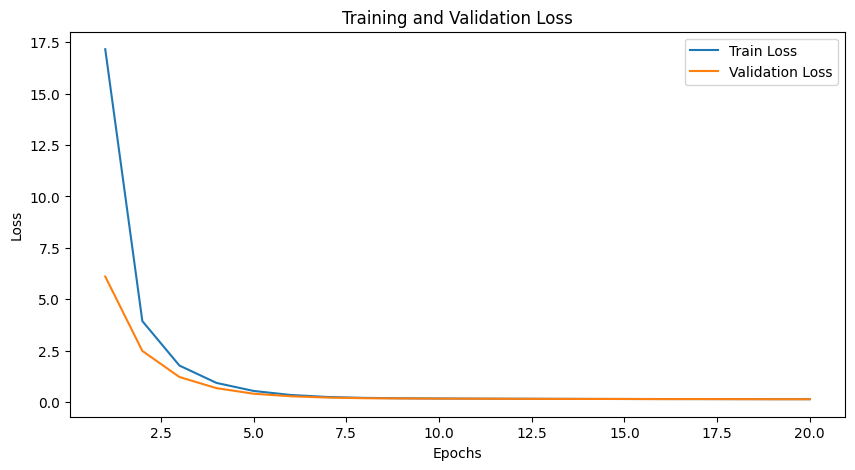

In [ ]:
embedding_net = LeNet5().to(device)
siamese_net = SiameseNetwork(embedding_net).to(device)
criterion_contrastive = ContrastiveLoss(margin=1.0)
optimizer_siamese = optim.Adam(siamese_net.parameters(), lr=0.001)

train = SiameseFashionMNIST(train_dataset)
val = SiameseFashionMNIST(val_dataset)
siamese_loader_train = DataLoader(train, batch_size=128, shuffle=True)
siamese_loader_val = DataLoader(val, batch_size=128, shuffle=False)

siamese_net = train_siamese(siamese_net, siamese_loader_train, siamese_loader_val, criterion_contrastive, optimizer_siamese, num_epochs=20)

In [ ]:
siamese_loader_test = DataLoader(SiameseFashionMNIST(test_dataset), batch_size=64, shuffle=False)
loss = validate_siamese(siamese_net, siamese_loader_test, criterion_contrastive)
loss

0.13939992303848267

<ipython-input-26-2bb170e04ff3>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img1_batch = torch.tensor(img1).unsqueeze(0).to(device)
<ipython-input-26-2bb170e04ff3>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img2_batch = torch.tensor(img2).unsqueeze(0).to(device)


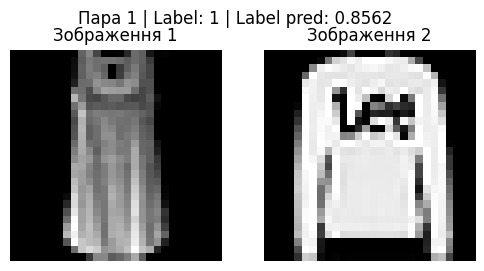

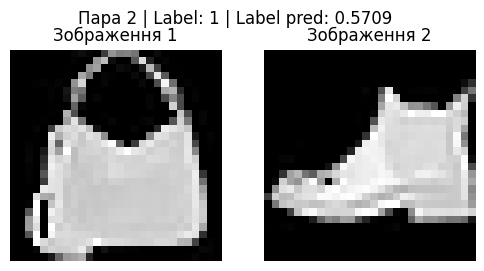

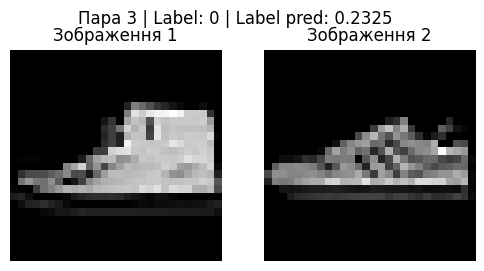

In [ ]:
import random


def threashold_contrastive_loss(input1, input2, m):
    """dist < m --> 1 else 0"""
    diff = input1 - input2
    dist_sq = torch.sum(torch.pow(diff, 2), 1)
    dist = torch.sqrt(dist_sq)
    threashold = dist.clone()
    threashold.data.fill_(m)
    return dist


num_pairs = 3

sample_indices = random.sample(range(len(SiameseFashionMNIST(test_dataset))), num_pairs)
pairs = [SiameseFashionMNIST(test_dataset)[i] for i in sample_indices]

siamese_net.eval()
for idx, (img1, img2, label) in enumerate(pairs):
    img1_batch = torch.tensor(img1).unsqueeze(0).to(device)
    img2_batch = torch.tensor(img2).unsqueeze(0).to(device)

    with torch.no_grad():
        emb1, emb2 = siamese_net(img1_batch, img2_batch)
        distance = F.pairwise_distance(emb1, emb2, p=2).item()

    img1_np = img1[0]
    img2_np = img2[0]

    fig, axs = plt.subplots(1, 2, figsize=(6, 3))
    axs[0].imshow(img1_np, cmap='gray')
    axs[0].set_title("Зображення 1")
    axs[0].axis("off")
    axs[1].imshow(img2_np, cmap='gray')
    axs[1].set_title("Зображення 2")
    axs[1].axis("off")

    plt.suptitle(f"Пара {idx+1} | Label: {int(label)} | Label pred: {threashold_contrastive_loss(emb1, emb2, 1.0).item():.4f}")
    plt.show()

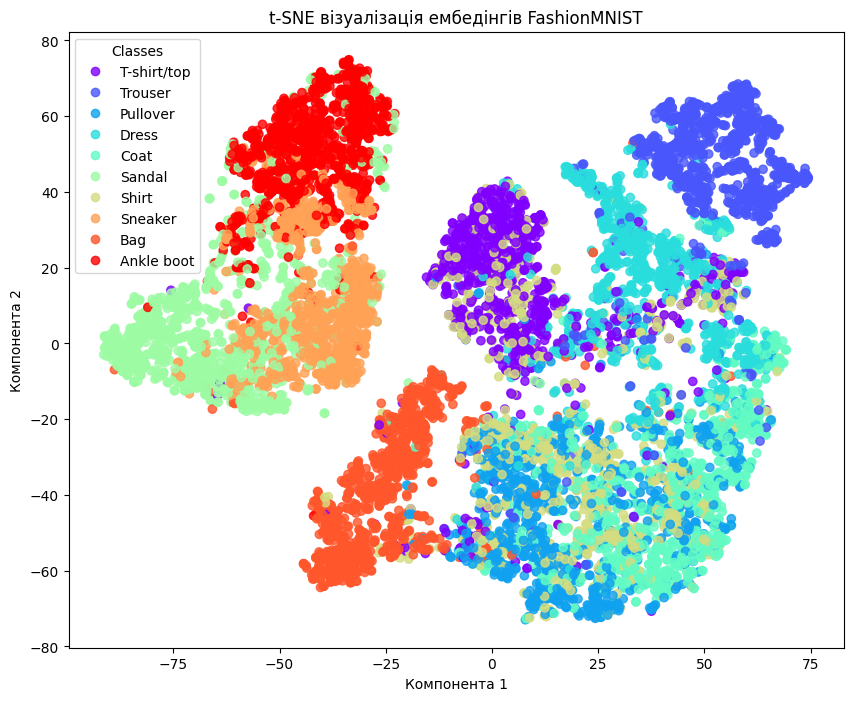

In [ ]:
embedding_net.eval()
embeddings = []
labels = []

with torch.no_grad():
    for data, target in test_loader:
        data = data.to(device)
        emb = siamese_net.forward_once(data)
        embeddings.append(emb.cpu().numpy())
        labels.append(target.numpy())

embeddings = np.vstack(embeddings)
labels = np.hstack(labels)

unique_labels = np.unique(labels)
class_names = [label_to_category(lbl) for lbl in unique_labels]

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(10,8))
scatter = plt.scatter(
    embeddings_2d[:, 0], embeddings_2d[:, 1],
    c=labels, cmap=plt.cm.rainbow,
    alpha=0.8
)
handles, _ = scatter.legend_elements()
plt.legend(handles, class_names, title="Classes")
plt.title("t-SNE візуалізація ембедінгів FashionMNIST")
plt.xlabel("Компонента 1")
plt.ylabel("Компонента 2")
plt.show()

**Висновк:** Застосування Siamese networks дозволило ефективно знаходити схожі зображення, що підтвердило дієвість методу в задачах візуального пошуку. Візуалізація простору ознак за допомогою t-SNE продемонструвала, що модель добре групує подібні об’єкти, що свідчить про коректне навчання мережі та якісне представлення ознак.